In [1]:
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os


# from diffusion_policy.env.pusht.pusht_image_env import PushTImageEnv
import imageio 
import torch
import torch.nn as nn
import torch.nn.functional as F

import h5py

from pusht_data_utils import get_data_stats, normalize_data, unnormalize_data, PushTImageDatasetFromHDF5
from vision_model import ResidualBlock, ResNetFe, replace_bn_with_gn
from noise_predictor_model import ConditionalUnet1D
from myddpm import MyScheduler, MyDDPM

import sys 
sys.path.append('/home/ns1254/diffusion_policy/')

from diffusion_policy.env.pusht.pusht_image_env import PushTImageEnv
import collections

import numpy as np
import matplotlib.pyplot as plt

/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.16, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# pred_horizon = 16
pred_horizon = 2 
obs_horizon = 2
action_horizon = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [3]:
hdf5_file_name='data/pusht/pusht_v7_zarr_206.hdf5'
dataset = PushTImageDatasetFromHDF5(
    hdf5_file_name=hdf5_file_name,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    hdf5_filter_key="f200"
)
stats=dataset.stats

In [4]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    num_workers=4,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

batch = next(iter(dataloader))
batch['image'].shape, batch['agent_pos'].shape, batch['action'].shape

(torch.Size([64, 2, 3, 96, 96]),
 torch.Size([64, 2, 2]),
 torch.Size([64, 2, 2]))

In [5]:
vision_encoder = ResNetFe(ResidualBlock, [2, 2]) 
vision_encoder = replace_bn_with_gn(vision_encoder)

In [6]:
class BC_Simple(nn.Module):
    def __init__(self, vision_encoder, action_dim, pred_horizon):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.action_dim = action_dim
        self.pred_horizon = pred_horizon

        self.fc = nn.Sequential(
            nn.Linear(512*2+2*2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim * pred_horizon)
        )

    def forward(self, x):
        x = self.vision_encoder(x)
        x = self.fc(x)
        return x

In [7]:
vision_feature_dim = 512
lowdim_obs_dim = 2

obs_dim = vision_feature_dim + lowdim_obs_dim
action_dim = 2

In [8]:
bc=BC_Simple(vision_encoder, 2, 1)
bc.to(device)


optimizer = torch.optim.Adam(bc.parameters(), lr=1e-4)
criteria = nn.MSELoss() 

In [9]:
epochs=500

losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for nbatch in dataloader:
        nimage = nbatch['image'][:,:obs_horizon].to(device)
        nagent_pos = nbatch['agent_pos'][:,:obs_horizon].to(device)
        naction = nbatch['action'].to(device)[:,:action_horizon].squeeze()
        

        image_features = bc.vision_encoder( nimage.flatten(end_dim=1))
        image_features = image_features.reshape(*nimage.shape[:2],-1)

        # concatenate vision feature and low-dim obs
        obs_features = torch.cat([image_features, nagent_pos], dim=-1)
        obs_cond = obs_features.flatten(start_dim=1)

        out=bc.fc(obs_cond)
        
        loss = criteria(out, naction)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss/len(dataloader)) 
    print(f"Epoch {epoch} Loss: {epoch_loss/len(dataloader) :.4f}")

/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/ns1254/miniforge3/envs/robodiff/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.0556
Epoch 1 Loss: 0.0036
Epoch 2 Loss: 0.0016
Epoch 3 Loss: 0.0007
Epoch 4 Loss: 0.0005
Epoch 5 Loss: 0.0004
Epoch 6 Loss: 0.0004
Epoch 7 Loss: 0.0003
Epoch 8 Loss: 0.0003
Epoch 9 Loss: 0.0003
Epoch 10 Loss: 0.0007
Epoch 11 Loss: 0.0003
Epoch 12 Loss: 0.0002
Epoch 13 Loss: 0.0002
Epoch 14 Loss: 0.0002
Epoch 15 Loss: 0.0002
Epoch 16 Loss: 0.0002
Epoch 17 Loss: 0.0002
Epoch 18 Loss: 0.0002
Epoch 19 Loss: 0.0002
Epoch 20 Loss: 0.0002
Epoch 21 Loss: 0.0002
Epoch 22 Loss: 0.0003
Epoch 23 Loss: 0.0002
Epoch 24 Loss: 0.0002
Epoch 25 Loss: 0.0002
Epoch 26 Loss: 0.0002
Epoch 27 Loss: 0.0002
Epoch 28 Loss: 0.0002
Epoch 29 Loss: 0.0002
Epoch 30 Loss: 0.0002
Epoch 31 Loss: 0.0002
Epoch 32 Loss: 0.0002
Epoch 33 Loss: 0.0002
Epoch 34 Loss: 0.0002
Epoch 35 Loss: 0.0002
Epoch 36 Loss: 0.0002
Epoch 37 Loss: 0.0002
Epoch 38 Loss: 0.0002
Epoch 39 Loss: 0.0002
Epoch 40 Loss: 0.0002
Epoch 41 Loss: 0.0002
Epoch 42 Loss: 0.0002
Epoch 43 Loss: 0.0002
Epoch 44 Loss: 0.0002
Epoch 45 Loss: 0.000

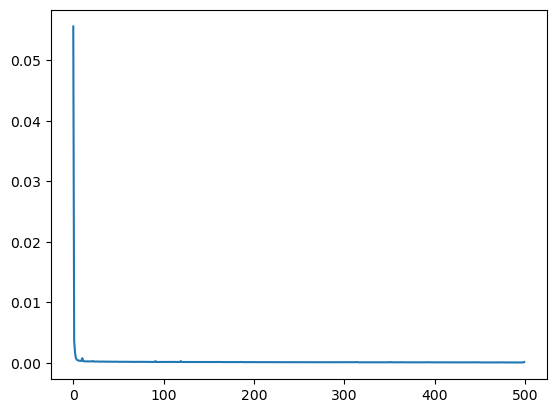

In [10]:
plt.plot(losses) 

In [11]:
env = PushTImageEnv()
bc.eval()
pass 

In [12]:
def rollout(env, bc,  seed, max_steps=200):
        
    env.seed(200+seed)
    obs = env.reset()

    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [obs] * obs_horizon, maxlen=obs_horizon)
    # save visualization and rewards
    imgs = [env.render(mode='rgb_array')]
    rewards = list()
    done = False
    step_idx = 0
    success=False
    with tqdm(total=max_steps, desc="Eval PushTImageEnv") as pbar:
        while not done:
            # stack the last obs_horizon number of observations
            images = np.stack([x['image'] for x in obs_deque])
            agent_poses = np.stack([x['agent_pos'] for x in obs_deque])

            # normalize observation
            nagent_poses = normalize_data(agent_poses, stats=stats['agent_pos'])
            # images are already normalized to [0,1]
            nimages = images

            # device transfer
            nimages = torch.from_numpy(nimages).to(device, dtype=torch.float32)
            # (2,3,96,96)
            nagent_poses = torch.from_numpy(nagent_poses).to(device, dtype=torch.float32)
            # (2,2)

            # infer action
            with torch.no_grad(): 
                image_features = bc.vision_encoder(nimages)
                # (2,512) 
                # concat with low-dim observations
                obs_features = torch.cat([image_features, nagent_poses], dim=-1) 
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)
                
                action = bc.fc(obs_cond)

            naction = action.cpu().numpy().reshape(-1,2)

            action_pred = unnormalize_data(naction, stats=stats['action'])
            action=action_pred 

            # execute action_horizon number of steps
            # without replanning
            for i in range(len(action)):
                obs, reward, done, info = env.step(action[i])
                obs_deque.append(obs)
                
                rewards.append(reward)
                imgs.append(env.render(mode='rgb_array'))

                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps:
                    done = True
                if done:
                    success=True
                    break

    return max(rewards) , success, imgs

In [13]:
rewards=[]
success=[]
lengths=[]
seed=40

np.random.seed(seed)
torch.manual_seed(seed)

for i in range(50):
    reward, suc, imgs = rollout(env, bc, seed+i, 200)
    rewards.append(reward)
    success.append(suc)
    lengths.append(len(imgs))

print('Mean Reward: ', np.mean(rewards))
print('Success Rate: ', np.mean(success))
print('Mean Length: ', np.mean(lengths))

Eval PushTImageEnv: 201it [00:00, 239.52it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 249.40it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 247.82it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 248.12it/s, reward=0.181]                         
Eval PushTImageEnv: 201it [00:00, 244.24it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 249.62it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 246.52it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 249.53it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 233.41it/s, reward=0.296]                         
Eval PushTImageEnv: 201it [00:00, 234.46it/s, reward=0.0438]                         
Eval PushTImageEnv: 201it [00:00, 238.97it/s, reward=0]                         
Eval PushTImageEnv: 201it [00:00, 233.61it/s, reward=0]                         
Eval PushTImage

Mean Reward:  0.06802843940156994
Success Rate:  1.0
Mean Length:  202.0


In [14]:
len(imgs)
import imageio 

imageio.mimsave('bc_custom_pusht.gif', imgs, duration=0.1)